In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [2]:
data = pd.read_csv('data/retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [4]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    recs = np.random.choice(items_weights['item_id'].values.ravel(), 5, replace=False, p=items_weights['weight'].values.ravel())
    
    return recs.tolist()

In [5]:
%%time
item_id = data['item_id'].unique()
weights = np.random.dirichlet(np.ones(item_id.shape[0]), size=1)
df = pd.DataFrame({'item_id': item_id, 'weight': weights.ravel()})
recs = weighted_random_recommendation(df)
recs

Wall time: 36.9 ms


[9526358, 6396337, 833904, 12949806, 10121716]

### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [6]:
result = pd.read_csv('data/predictions_basic.csv')
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,[ 821867 834484 856942 865456 889248 ...,"[8157117, 870291, 1846901, 891748, 1038560]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 1029743, 995785, 1004906, 1081177]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[1000965, 10121560, 9878622, 13512901, 13039531]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1127831, 1068719]"


In [7]:
actual = data_test.groupby('user_id')['item_id'].unique().reset_index()
actual.head()

,user_id,item_id
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."


In [8]:
result.drop(columns='actual', axis=1, inplace=True)

In [9]:
result = result.merge(actual, how='left', on='user_id')
result.rename(columns={'item_id': 'actual'}, inplace=True)
result.head()

,user_id,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,actual
0,1,"[8157117, 870291, 1846901, 891748, 1038560]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 1029743, 995785, 1004906, 1081177]","[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[1000965, 10121560, 9878622, 13512901, 13039531]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1127831, 1068719]","[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[5129567, 6555376, 9487756, 6533880, 1117945]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]","[1082185, 1029743, 6534178, 1127831, 995785]","[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[15740824, 9423981, 1052258, 13986798, 1003354]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 961554, 1098066]","[1082185, 981760, 1127831, 961554, 826249]","[1082185, 1029743, 1127831, 995785, 1044078]","[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[1964658, 954745, 976261, 7025202, 1054432]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 1098066, 995242]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 1029743, 1098066, 6534178, 1127831]","[835098, 872137, 910439, 924610, 992977, 10412..."


In [10]:
def str_to_list(string):
    if isinstance(string, list) or isinstance(string, int) or isinstance(string, np.ndarray):
        return string
    elif isinstance(string, str):
        result = []
        splitted_list = string[1:-1].split(', ')
        for value in splitted_list:
            try:
                result.append(int(value))
            except ValueError:
                print(f'Value {value} not added')
        return result
    else:
        raise ValueError('Wrong value passed')

In [11]:
for column in result.columns:
    result[column] = result[column].map(str_to_list)

Value  not added
Value  not added
Value  not added
Value  not added
Value  not added
Value  not added
Value  not added
Value  not added


In [12]:
def precision_at_k_(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [13]:
def precision_at_k_for_df(df, k=5):
    columns = [x for x in df.columns if x not in ['actual', 'user_id']]
    result = []
    for column in columns:
        column_precisions = []
        for rec_list, bought_list in zip(df[column], df['actual']):
            column_precisions.append(precision_at_k_(rec_list, bought_list))
        result.append(np.mean(column_precisions))

    result = dict(zip(columns, result))
    return result

In [14]:
precision_at_k_for_df(result)

<ipython-input-12-6bc63ff107ef>:11: RuntimeWarning: invalid value encountered in long_scalars
  precision = flags.sum() / len(recommended_list)


{'random_recommendation': 0.0005876591576885408,
 'popular_recommendation': 0.15523996082272282,
 'itemitem': 0.15132223310479923,
 'cosine': 0.155435847208619,
 'tfidf': 0.16121449559255635,
 'own_purchases': nan}

Поидее own_purchases должен быть 1, но я не разобрался почему он его не считает.

### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ- {2000, 5000, 10000} товаров. Постройте график зависимости precision@5 от топ-*
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$. Постройте график зависимости precision@5 от $K$ 

In [15]:
base_df = data_test.groupby('user_id')['item_id'].unique().reset_index()
base_df.columns=['user_id', 'actual']

In [17]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [18]:
baseline_1 = base_df.copy()
top_n_list = range(1000, 11000, 1000)
for n in top_n_list:
    top_n = data_train.groupby('item_id')['sales_value'].sum().sort_values(ascending=False).index[:n]
    baseline_1['random_recommendation_at_top_'+str(n)] = baseline_1['user_id'].apply(lambda x: random_recommendation(top_n))

In [19]:
precisions_random = precision_at_k_for_df(baseline_1)
precisions_random

{'random_recommendation_at_top_1000': 0.014103819784524978,
 'random_recommendation_at_top_2000': 0.009598432908912831,
 'random_recommendation_at_top_3000': 0.006758080313418218,
 'random_recommendation_at_top_4000': 0.006072477962781587,
 'random_recommendation_at_top_5000': 0.0047992164544564155,
 'random_recommendation_at_top_6000': 0.005778648383937317,
 'random_recommendation_at_top_7000': 0.004015670910871695,
 'random_recommendation_at_top_8000': 0.0039177277179236044,
 'random_recommendation_at_top_9000': 0.0039177277179236044,
 'random_recommendation_at_top_10000': 0.0042115572967678745}

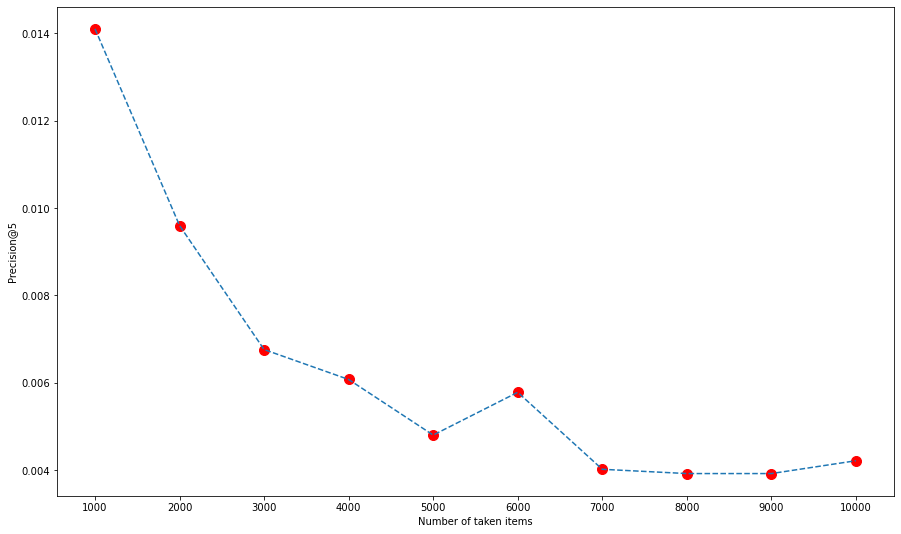

In [20]:
precisions_list = [x for x in precisions_random.values()]
plt.figure(figsize=(15,9))
plt.scatter(list(top_n_list), precisions_list, s=100.0, color='red')
plt.plot(list(top_n_list), precisions_list, linestyle='dashed')
plt.xticks(top_n_list)
plt.xlabel('Number of taken items')
plt.ylabel('Precision@5')
plt.show()

In [21]:
baseline_2 = base_df.copy()
log_sales = []
sales = data_train.groupby('item_id')['sales_value'].sum().sort_values(ascending=False)
for value in sales:
    if value != 0:
        log_sales.append(np.log(value))
    else:
        log_sales.append(0)
        
log_sales = np.array(log_sales)
for n in top_n_list:
    weights = []
    top_n = sales.index[:n]
    log_sum = np.sum(log_sales[:n])
    for value in log_sales[:n]:
        weights.append(value/log_sum)
    item_weights = pd.DataFrame({'item_id': top_n, 'weight': weights})
    baseline_2['weighted_random_recommendation_at_top_'+str(n)] = baseline_2['user_id'].\
                                                                  apply(lambda x: weighted_random_recommendation(item_weights))

In [22]:
precisions_weighted_random = precision_at_k_for_df(baseline_2)
precisions_weighted_random

{'weighted_random_recommendation_at_top_1000': 0.014495592556317336,
 'weighted_random_recommendation_at_top_2000': 0.00999020568070519,
 'weighted_random_recommendation_at_top_3000': 0.010577864838393732,
 'weighted_random_recommendation_at_top_4000': 0.006953966699314397,
 'weighted_random_recommendation_at_top_5000': 0.006953966699314398,
 'weighted_random_recommendation_at_top_6000': 0.005876591576885406,
 'weighted_random_recommendation_at_top_7000': 0.005876591576885406,
 'weighted_random_recommendation_at_top_8000': 0.004603330068560236,
 'weighted_random_recommendation_at_top_9000': 0.0042115572967678745,
 'weighted_random_recommendation_at_top_10000': 0.004113614103819786}

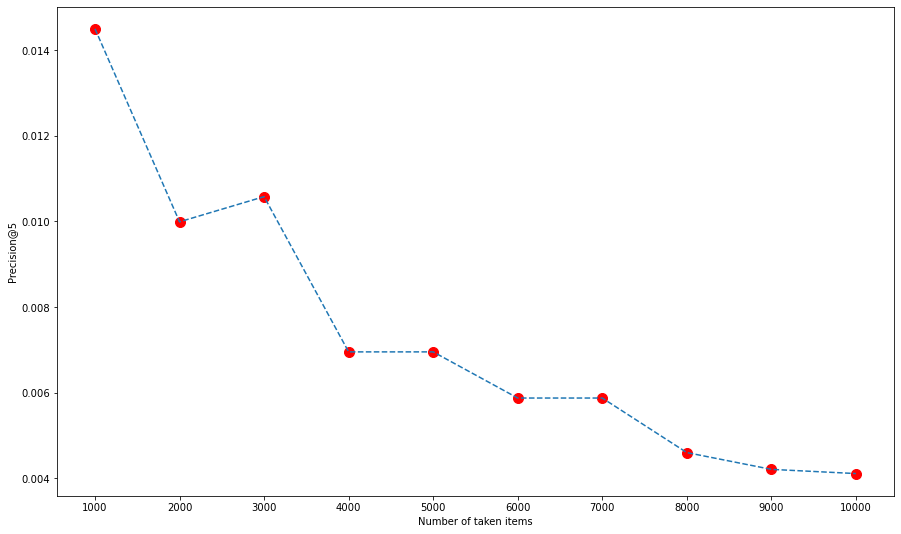

In [23]:
precisions_list = [x for x in precisions_weighted_random.values()]
plt.figure(figsize=(15,9))
plt.scatter(list(top_n_list), precisions_list, s=100.0, color='red')
plt.plot(list(top_n_list), precisions_list, linestyle='dashed')
plt.xticks(top_n_list)
plt.xlabel('Number of taken items')
plt.ylabel('Precision@5')
plt.show()

In [24]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [25]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [26]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [28]:
%%time
itemitem_recs = base_df.copy()

for k in range(4,11):
    model = ItemItemRecommender(K=k, num_threads=4) # K - кол-во билжайших соседей

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=True)
    
    itemitem_recs['itemitem_k='+str(k)] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])


Wall time: 4.32 s


In [29]:
precisions_itemitem = precision_at_k_for_df(itemitem_recs)
precisions_itemitem

{'itemitem_k=4': 0.04123408423114594,
 'itemitem_k=5': 0.03359451518119491,
 'itemitem_k=6': 0.03192948090107738,
 'itemitem_k=7': 0.03143976493633693,
 'itemitem_k=8': 0.03173359451518119,
 'itemitem_k=9': 0.0306562193927522,
 'itemitem_k=10': 0.030460333006856025}

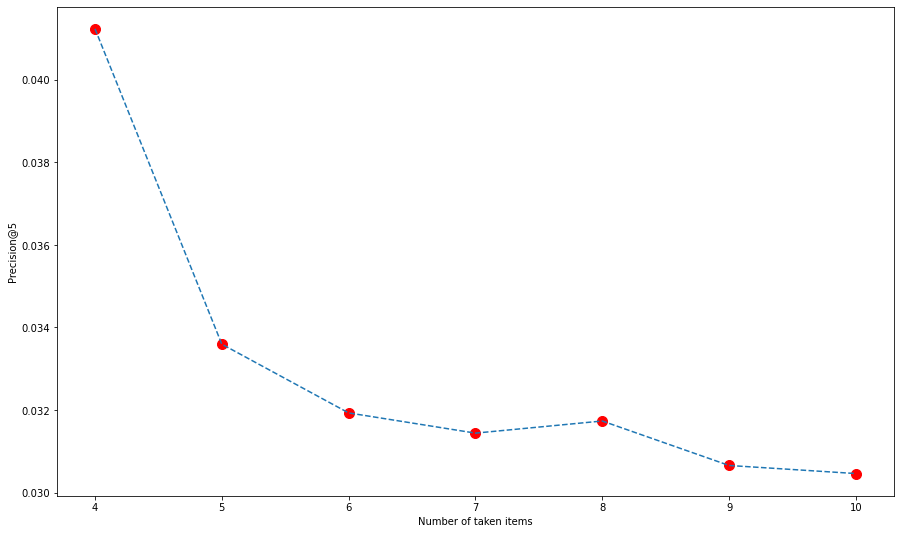

In [30]:
precisions_list = [x for x in precisions_itemitem.values()]
plt.figure(figsize=(15,9))
plt.scatter(list(range(4,11)), precisions_list, s=100.0, color='red')
plt.plot(list(range(4,11)), precisions_list, linestyle='dashed')
plt.xticks(range(4,11))
plt.xlabel('Number of taken items')
plt.ylabel('Precision@5')
plt.show()